In [5]:
import pandas_gbq
import os

# Set up authentication (replace the path with the path to your credentials JSON file)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/machine-learning-435622-1a5d83327d89.json"

# Set your Google Cloud project ID
project_id = "machine-learning-435622"

# SQL query to fetch data for all cities across all available years
query = """
SELECT *
FROM `bigquery-public-data.openaq.global_air_quality`
ORDER BY
    timestamp
"""

# Execute the query and load the data into a pandas DataFrame
df = pandas_gbq.read_gbq(query, project_id=project_id, location='US')

# Save the data to a CSV file (optional)
df.to_csv('air_quality_data_all_cities_all_years.csv', index=False)

# Alternatively, save the data as a Parquet file for more efficient storage
df.to_parquet('air_quality_data_all_cities_all_years.parquet', index=False)

# Display the first few rows of the DataFrame
print(df.head())

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
            location   city country pollutant  value  \
0    JTC - Jamestown  Accra      GH      pm25  51.77   
1    JTC - Jamestown  Accra      GH      pm10  99.32   
2    JTC - Jamestown  Accra      GH      pm25  51.77   
3    JTC - Jamestown  Accra      GH      pm10  99.32   
4  ADT - Asylum Down  Accra      GH      pm10  74.27   

                  timestamp   unit                         source_name  \
0 2007-02-09 07:00:00+00:00  µg/m³  Dr. Raphael E. Arku and Colleagues   
1 2007-02-09 07:00:00+00:00  µg/m³  Dr. Raphael E. Arku and Colleagues   
2 2007-02-09 07:00:00+00:00  µg/m³  Dr. Raphael E. Arku and Colleagues   
3 2007-02-09 07:00:00+00:00  µg/m³  Dr. Raphael E. Arku and Colleagues   
4 2007-04-08 06:20:00+00:00  µg/m³  Dr. Raphael E. Arku and Colleagues   

    latitude  longitude  averaged_over_in_hours                location_geom  
0  44.000000   5.53

In [6]:
df.shape

(5594614, 12)

In [19]:
import pandas as pd

# Assuming 'df' is your DataFrame containing the 'timestamp' column
df = pd.read_csv('air_quality_data_all_cities_all_years.csv')  # Load your data

# Convert the 'timestamp' column to datetime (if not already in datetime format)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Find the latest timestamp
latest_timestamp = df['timestamp'].max()

print(f"The latest timestamp in the dataset is: {latest_timestamp}")

The latest timestamp in the dataset is: 2022-05-26 18:00:00+00:00


In [155]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

# API endpoints
measurements_url = "https://api.openaq.org/v2/measurements"
parameters_url = "https://api.openaq.org/v2/parameters"

# OpenAQ API key
api_key = '764bc5b046eebfd7cd4fb10f2e16cbd6b83acc554c6802467bf630867999ca79'

# Headers including the correct 'x-api-key' header
headers = {
    'x-api-key': api_key
}

# Cities list
cities = ['London']

# Pollutants to fetch
parameters_response = requests.get(parameters_url, headers=headers)
pollutants = [parameter['id'] for parameter in parameters_response.json()['results']]

# Initialize an empty list to store the processed data
air_quality_data = []

# Function to generate monthly date ranges from January 2023 to August 2024
def generate_monthly_date_ranges(start_date, end_date):
    date_ranges = []
    current_date = start_date
    while current_date < end_date:
        next_month = (current_date.replace(day=1) + timedelta(days=32)).replace(day=1)
        date_ranges.append((
            current_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            (next_month - timedelta(seconds=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
        ))
        current_date = next_month
    return date_ranges

# Start date: January 1, 2023, End date: August 31, 2024
start_date = datetime(2023, 1, 1, 0, 0, 0)
end_date = datetime(2024, 8, 31, 23, 59, 59)

# Generate the date ranges
date_ranges = generate_monthly_date_ranges(start_date, end_date)

# Function to handle API requests with exponential backoff strategy
def fetch_data_with_backoff(city, pollutant, date_from, date_to, page=1):
    wait_time = 120  # Initial wait time for rate limiting
    while True:
        try:
            params = {
                'city': city,
                'limit': 100,
                'parameter_id': pollutant,
                'date_from': date_from,
                'date_to': date_to,
                'page': page
            }
            response = requests.get(measurements_url, headers=headers, params=params)
            if response.status_code == 429:  # Rate-limited
                print(f"Rate limited. Waiting for {wait_time} seconds before retrying...")
                time.sleep(wait_time)
                wait_time *= 2  # Exponentially increase the wait time on each retry
                continue
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Failed to fetch data for {city} - {pollutant}. HTTP Status code: {response.status_code}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Error occurred: {e}")
            return None

# Fetch data in batches with delays
# Define wait times to throttle requests (adjust if needed)
throttle_wait_time = 0.5  # Wait time between requests for each city-pollutant-date combination
batch_wait_time = 120  # Wait time between city batches (5 minutes)
batch_size = 5  # Adjust batch size as needed

# Process data for each city in batches
for i in range(0, len(cities), batch_size):
    city_batch = cities[i:i + batch_size]
    for city in city_batch:
        for pollutant in pollutants:
            for date_from, date_to in date_ranges:
                page = 1
                while True:
                    data = fetch_data_with_backoff(city, pollutant, date_from, date_to, page)
                    if not data:
                        break

                    results = data.get('results', [])
                    if not results:
                        break

                    for result in results:
                        air_quality_data.append({
                            'location': result['location'],
                            'city': result['city'],
                            'country': result['country'],
                            'parameter': result['parameter'],
                            'value': result['value'],
                            'unit': result['unit'],
                            'date': result['date']['utc'],
                            'coordinates': result['coordinates'] if 'coordinates' in result else None,
                            'averagingPeriod': result['averagingPeriod']['value'] if 'averagingPeriod' in result else None,
                            'sourceType': result['sourceType'] if 'sourceType' in result else None,
                            'isMobile': result['isMobile'] if 'isMobile' in result else None,
                        })

                    # Move to the next page
                    page += 1

                # Wait between each city-pollutant request to prevent rate limiting
                print(f"Throttling: Waiting for {throttle_wait_time} seconds before next request...")
                time.sleep(throttle_wait_time)

    # Wait between city batches
    print(f"Finished batch {i // batch_size + 1}. Waiting for {batch_wait_time} seconds before next batch...")
    time.sleep(batch_wait_time)

# Save the data to CSV
df = pd.DataFrame(air_quality_data)
df.to_csv('air_quality_data.csv', index=False)
print("Data saved to 'air_quality_data.csv'")


Throttling: Waiting for 0.5 seconds before next request...
Throttling: Waiting for 0.5 seconds before next request...
Throttling: Waiting for 0.5 seconds before next request...
Throttling: Waiting for 0.5 seconds before next request...
Rate limited. Waiting for 120 seconds before retrying...
Throttling: Waiting for 0.5 seconds before next request...
Rate limited. Waiting for 120 seconds before retrying...
Throttling: Waiting for 0.5 seconds before next request...
Throttling: Waiting for 0.5 seconds before next request...
Rate limited. Waiting for 120 seconds before retrying...
Throttling: Waiting for 0.5 seconds before next request...
Rate limited. Waiting for 120 seconds before retrying...
Throttling: Waiting for 0.5 seconds before next request...
Throttling: Waiting for 0.5 seconds before next request...
Rate limited. Waiting for 120 seconds before retrying...
Throttling: Waiting for 0.5 seconds before next request...
Rate limited. Waiting for 120 seconds before retrying...
Throttlin

## Data Cleaning

### Combining the Data

In [1101]:
df1 = pd.read_csv('air_quality_data_all_cities_all_years.csv')

In [1102]:
df1.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,JTC - Jamestown,Accra,GH,pm25,51.77,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,44.000000,5.534919,-0.212406,POINT(5.5349194 44)
1,JTC - Jamestown,Accra,GH,pm10,99.32,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,44.000000,5.534919,-0.212406,POINT(5.5349194 44)
2,JTC - Jamestown,Accra,GH,pm25,51.77,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.534919,-0.212406,48.000000,POINT(-0.2124056 5.5349193)
3,JTC - Jamestown,Accra,GH,pm10,99.32,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.534919,-0.212406,48.000000,POINT(-0.2124056 5.5349193)
4,ADT - Asylum Down,Accra,GH,pm10,74.27,2007-04-08 06:20:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,45.000000,5.570722,-0.212056,POINT(5.570722 45)


In [1103]:
df2 = pd.read_csv('air_quality_data.csv')

In [1104]:
df2.head()

,location,city,country,parameter,value,unit,date,coordinates,averagingPeriod,sourceType,isMobile
0,London Harlington,NaN,GB,pm10,13.0,µg/m³,2023-01-31T23:00:00+00:00,"{'latitude': 51.48879, 'longitude': -0.441614}",NaN,NaN,False
1,London Harlington,NaN,GB,pm10,13.0,µg/m³,2023-01-31T22:00:00+00:00,"{'latitude': 51.48879, 'longitude': -0.441614}",NaN,NaN,False
2,London Harlington,NaN,GB,pm10,13.0,µg/m³,2023-01-31T21:00:00+00:00,"{'latitude': 51.48879, 'longitude': -0.441614}",NaN,NaN,False
3,London Harlington,NaN,GB,pm10,13.0,µg/m³,2023-01-31T20:00:00+00:00,"{'latitude': 51.48879, 'longitude': -0.441614}",NaN,NaN,False
4,London Harlington,NaN,GB,pm10,13.0,µg/m³,2023-01-31T19:00:00+00:00,"{'latitude': 51.48879, 'longitude': -0.441614}",NaN,NaN,False


In [1105]:
df2['city'] = df2['city'].fillna('London')

In [1106]:
import ast

# Convert the 'coordinates' column from string to dictionary format
df2['coordinates'] = df2['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extracting Latitude and Longitude from the 'coordinates' dictionary
df2['latitude'] = df2['coordinates'].apply(lambda x: x['latitude'] if isinstance(x, dict) and 'latitude' in x else None)
df2['longitude'] = df2['coordinates'].apply(lambda x: x['longitude'] if isinstance(x, dict) and 'longitude' in x else None)

# Creating the new 'location_geom' column in the correct format
df2['location_geom'] = df2.apply(lambda row: f"POINT({row['longitude']} {row['latitude']})" if pd.notnull(row['longitude']) and pd.notnull(row['latitude']) else None, axis=1)

# Dropping the old 'coordinates' column
df2 = df2.drop(columns=['coordinates'])

# Display the updated DataFrame
df2.head()

,location,city,country,parameter,value,unit,date,averagingPeriod,sourceType,isMobile,latitude,longitude,location_geom
0,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T23:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
1,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T22:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
2,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T21:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
3,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T20:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
4,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T19:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)


In [1107]:
# Rename API data columns to match BigQuery
df2.rename(columns={
    'parameter': 'pollutant',
    'date': 'timestamp',
    'averagingPeriod': 'averaged_over_in_hours',
    'sourceType': 'source_name'
}, inplace=True)

In [1108]:
df2.head()

,location,city,country,pollutant,value,unit,timestamp,averaged_over_in_hours,source_name,isMobile,latitude,longitude,location_geom
0,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T23:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
1,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T22:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
2,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T21:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
3,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T20:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)
4,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T19:00:00+00:00,NaN,NaN,False,51.48879,-0.441614,POINT(-0.441614 51.48879)


In [1109]:
df2 = df2.drop(columns=['isMobile'])

# Display the updated DataFrame
df2.head()

,location,city,country,pollutant,value,unit,timestamp,averaged_over_in_hours,source_name,latitude,longitude,location_geom
0,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T23:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
1,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T22:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
2,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T21:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
3,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T20:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
4,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31T19:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)


In [1110]:
df1.dtypes

location                   object
city                       object
country                    object
pollutant                  object
value                     float64
timestamp                  object
unit                       object
source_name                object
latitude                  float64
longitude                 float64
averaged_over_in_hours    float64
location_geom              object
dtype: object

In [1111]:
df2.dtypes

location                   object
city                       object
country                    object
pollutant                  object
value                     float64
unit                       object
timestamp                  object
averaged_over_in_hours    float64
source_name               float64
latitude                  float64
longitude                 float64
location_geom              object
dtype: object

In [1112]:
# Convert the 'source_name' column to numeric (float64), invalid parsing will be set as NaN
df2['source_name'] = pd.to_numeric(df2['source_name'], errors='coerce')

# Check the result
print(df2['source_name'].dtypes)

float64


In [1113]:
df2.dtypes

location                   object
city                       object
country                    object
pollutant                  object
value                     float64
unit                       object
timestamp                  object
averaged_over_in_hours    float64
source_name               float64
latitude                  float64
longitude                 float64
location_geom              object
dtype: object

In [1114]:
# Convert the 'timestamp' column to the correct format
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format='%Y-%m-%dT%H:%M:%S%z')

# Format the 'timestamp' with the required timezone format including the colon in the timezone offset
df2['timestamp'] = df2['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S%z')
df2['timestamp'] = df2['timestamp'].str[:-2] + ':' + df2['timestamp'].str[-2:]

# Display the updated DataFrame
df2.head()

,location,city,country,pollutant,value,unit,timestamp,averaged_over_in_hours,source_name,latitude,longitude,location_geom
0,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31 23:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
1,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31 22:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
2,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31 21:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
3,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31 20:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)
4,London Harlington,London,GB,pm10,13.0,µg/m³,2023-01-31 19:00:00+00:00,NaN,NaN,51.48879,-0.441614,POINT(-0.441614 51.48879)


In [1115]:
# Combine the two datasets
combined_df = pd.concat([df1, df2])

# Save the combined dataset
combined_df.to_csv('combined_air_quality_data.csv', index=False)

In [1116]:
df = pd.read_csv('combined_air_quality_data.csv')

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\3769611557.py:1: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [1117]:
df.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,JTC - Jamestown,Accra,GH,pm25,51.77,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,44.000000,5.534919,-0.212406,POINT(5.5349194 44)
1,JTC - Jamestown,Accra,GH,pm10,99.32,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,44.000000,5.534919,-0.212406,POINT(5.5349194 44)
2,JTC - Jamestown,Accra,GH,pm25,51.77,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.534919,-0.212406,48.000000,POINT(-0.2124056 5.5349193)
3,JTC - Jamestown,Accra,GH,pm10,99.32,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.534919,-0.212406,48.000000,POINT(-0.2124056 5.5349193)
4,ADT - Asylum Down,Accra,GH,pm10,74.27,2007-04-08 06:20:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,45.000000,5.570722,-0.212056,POINT(5.570722 45)


### Data Cleaning

In [1119]:
# Sort the DataFrame by the 'timestamp' column
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Display the sorted DataFrame
df.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,JTC - Jamestown,Accra,GH,pm25,51.77,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,44.000000,5.534919,-0.212406,POINT(5.5349194 44)
1,JTC - Jamestown,Accra,GH,pm10,99.32,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,44.000000,5.534919,-0.212406,POINT(5.5349194 44)
2,JTC - Jamestown,Accra,GH,pm25,51.77,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.534919,-0.212406,48.000000,POINT(-0.2124056 5.5349193)
3,JTC - Jamestown,Accra,GH,pm10,99.32,2007-02-09 07:00:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.534919,-0.212406,48.000000,POINT(-0.2124056 5.5349193)
4,ADT - Asylum Down,Accra,GH,pm10,74.27,2007-04-08 06:20:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,45.000000,5.570722,-0.212056,POINT(5.570722 45)


In [1120]:
df.tail()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
6031052,London N. Kensington,London,GB,so2,0.8,2024-08-31 23:00:00+00:00,µg/m³,NaN,51.521050,-0.213492,NaN,POINT(-0.21349199999999996 51.52105)
6031053,Haringey Roadside,London,GB,no2,43.6,2024-08-31 23:00:00+00:00,µg/m³,NaN,51.599300,-0.068218,NaN,POINT(-0.068218 51.5993)
6031054,Southwark A2 Old Kent Road,London,GB,pm10,29.0,2024-08-31 23:00:00+00:00,µg/m³,NaN,51.480499,-0.059550,NaN,POINT(-0.05955 51.480499)
6031055,London N. Kensington,London,GB,co,0.0,2024-08-31 23:00:00+00:00,µg/m³,NaN,51.521050,-0.213492,NaN,POINT(-0.21349199999999996 51.52105)
6031056,Southwark A2 Old Kent Road,London,GB,no2,21.4,2024-08-31 23:00:00+00:00,µg/m³,NaN,51.480499,-0.059550,NaN,POINT(-0.05955 51.480499)


#### Step 1: Cleaning the Data
The primary focus is to remove missing values, incorrect values, and outliers. We’ll also clean up any unnecessary columns.

In [1122]:
missing_values = df.isna().sum()

# Display the result
missing_values

location                     756
city                       73612
country                        0
pollutant                      0
value                          0
timestamp                      0
unit                           0
source_name               436443
latitude                       0
longitude                      1
averaged_over_in_hours    436444
location_geom                  1
dtype: int64

#### One NaN for longitude so it can be dropped.

In [1124]:
df.columns

Index(['location', 'city', 'country', 'pollutant', 'value', 'timestamp',
       'unit', 'source_name', 'latitude', 'longitude',
       'averaged_over_in_hours', 'location_geom'],
      dtype='object')

In [1125]:
df = df.dropna(subset=['longitude'])

In [1126]:
df.isna().sum()

location                     756
city                       73612
country                        0
pollutant                      0
value                          0
timestamp                      0
unit                           0
source_name               436443
latitude                       0
longitude                      0
averaged_over_in_hours    436443
location_geom                  0
dtype: int64

In [1127]:
df1[df1['city'] == 'London'].groupby('source_name')['pollutant'].value_counts()

source_name                 pollutant
DEFRA                       no2          6267
                            pm10         4592
                            pm25         4172
                            o3           3913
                            so2          1917
                            co            393
London Air Quality Network  no2            82
                            pm10           67
                            pm25           59
                            o3             42
                            so2            41
                            co             25
Name: count, dtype: int64

#### Since DEFRA has been the source for a lot of datapoints. The source_name for the latest data acquired from the API can be replaced with DEFRA instead of dropping because it's empty.

In [1129]:
df['source_name'] = df['source_name'].fillna('DEFRA')

In [1130]:
df.isna().sum()

location                     756
city                       73612
country                        0
pollutant                      0
value                          0
timestamp                      0
unit                           0
source_name                    0
latitude                       0
longitude                      0
averaged_over_in_hours    436443
location_geom                  0
dtype: int64

In [1131]:
number_of_locations = df['location'].nunique()
number_of_locations

10809

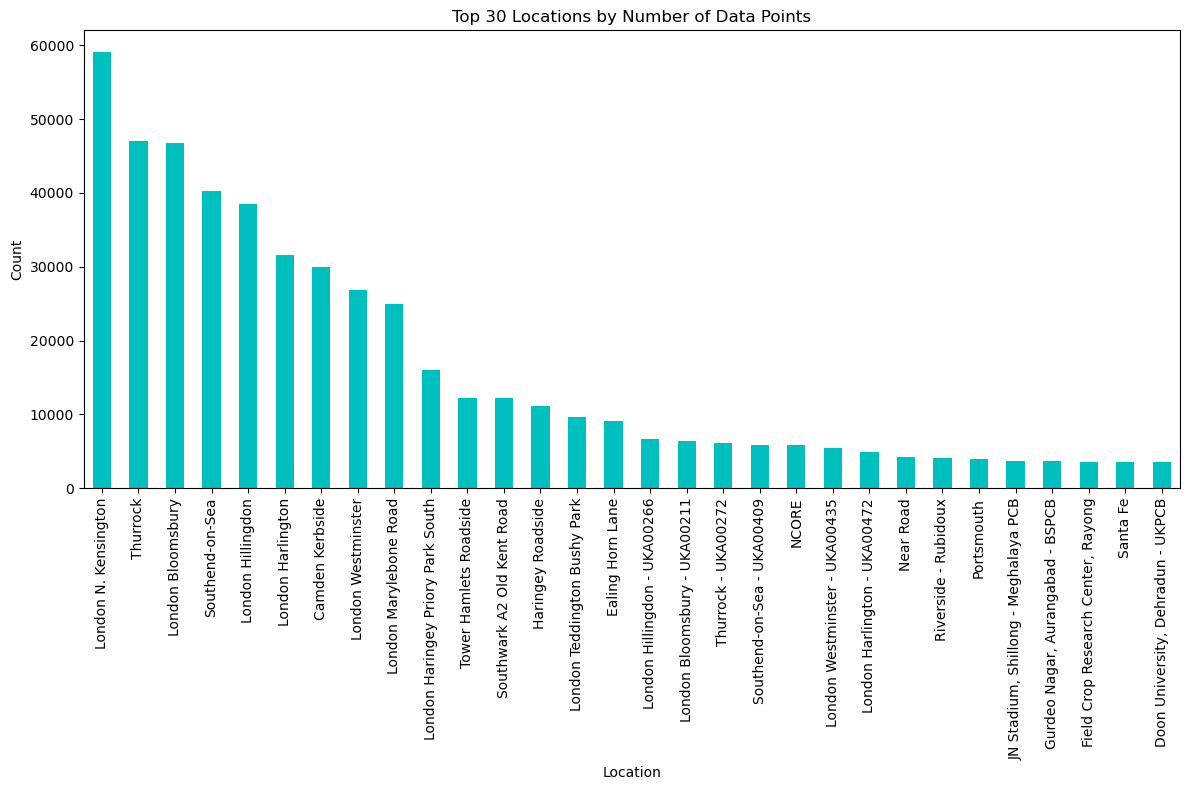

In [1132]:
import matplotlib.pyplot as plt

# Get the value counts of locations
location_counts = df['location'].value_counts()

# Select the top 30 locations
top_30_locations = location_counts.head(30)

# Plot the top 30 locations
plt.figure(figsize=(12, 8))
top_30_locations.plot(kind='bar', color='c')
plt.title('Top 30 Locations by Number of Data Points')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

Missing values in 'averaged_over_in_hours': 436443


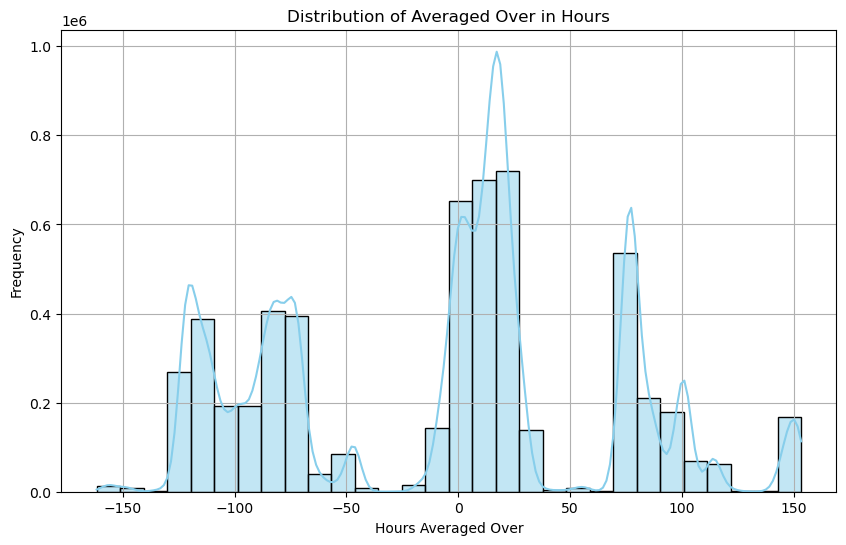

In [1133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values in the column
missing_values = df['averaged_over_in_hours'].isna().sum()
print(f"Missing values in 'averaged_over_in_hours': {missing_values}")

# Remove missing values before plotting
df_clean = df.dropna(subset=['averaged_over_in_hours'])

# Plotting the histogram for non-missing values
plt.figure(figsize=(10,6))
sns.histplot(df_clean['averaged_over_in_hours'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Averaged Over in Hours')
plt.xlabel('Hours Averaged Over')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

#### Based on the histogram, it appears that the column averaged_over_in_hours has a strange distribution, including negative values, which don’t make logical sense in the context of averaging hours. Therefore, its best to drop the column

In [1135]:
df = df.drop(columns=['averaged_over_in_hours'])

In [1136]:
df.isna().sum()

location           756
city             73612
country              0
pollutant            0
value                0
timestamp            0
unit                 0
source_name          0
latitude             0
longitude            0
location_geom        0
dtype: int64

In [1137]:
unique_lat_long_missing_city = df[df['city'].isna()][['latitude', 'longitude']].drop_duplicates()

# Display the unique latitudes and longitudes
print(unique_lat_long_missing_city)

         latitude   longitude
6654      1.00000   45.601760
6655     45.60176  -73.541990
10161    43.64543  -79.389080
10198     1.00000   48.167100
10199    48.16710 -118.974750
...           ...         ...
1935064   1.00000   49.282000
1935298   1.00000   49.288000
1935596   1.00000   49.300000
1936835   1.00000   49.368000
3295763   1.00000   21.021939

[145 rows x 2 columns]


In [1138]:
import requests
import pandas as pd
import time

# Initialize the OpenCage API (replace with your actual key)
api_key = '10fa2573a59d4b4090b3f8d5606e5613'
api_url = "https://api.opencagedata.com/geocode/v1/json"

# Function to perform reverse geocoding using OpenCage
def reverse_geocode(lat, lon):
    try:
        params = {
            'q': f'{lat},{lon}',
            'key': api_key,
            'no_annotations': 1,  # Simplifies the response
            'limit': 1  # We only need one result
        }
        response = requests.get(api_url, params=params)
        data = response.json()
        if response.status_code == 200 and data['results']:
            address_components = data['results'][0]['components']
            city = address_components.get('city', None)
            location = address_components.get('road', None)
            return city, location
        else:
            return None, None
    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None

# Load the unique latitudes and longitudes for rows with missing city/location values
unique_lat_long_missing_city = df[df['city'].isna()][['latitude', 'longitude']].drop_duplicates()

# Initialize a list to store the city and location names
city_location_data = []

# Loop through each latitude and longitude
for index, row in unique_lat_long_missing_city.iterrows():
    lat, lon = row['latitude'], row['longitude']
    city, location = reverse_geocode(lat, lon)
    city_location_data.append({'latitude': lat, 'longitude': lon, 'city_new': city, 'location_new': location})
    print(f"Processed lat: {lat}, lon: {lon} -> City: {city}, Location: {location}")
    
    # Add a delay to avoid exceeding the API rate limits (1 request per second)
    time.sleep(1)

# Create a DataFrame for the reverse geocoded data
city_location_df = pd.DataFrame(city_location_data)

# Save the city and location values to a separate CSV file
city_location_df.to_csv('city_location_geocoded_data.csv', index=False)

print("Geocoding completed and saved to 'city_location_geocoded_data.csv'.")


Processed lat: 1.0, lon: 45.60176 -> City: None, Location: None
Processed lat: 45.60176, lon: -73.54199 -> City: None, Location: None
Processed lat: 43.64543, lon: -79.38908 -> City: None, Location: None
Processed lat: 1.0, lon: 48.1671 -> City: None, Location: None
Processed lat: 48.1671, lon: -118.97475 -> City: None, Location: None
Processed lat: 1.0, lon: 30.6247 -> City: None, Location: None
Processed lat: 24.42431, lon: 54.433872 -> City: None, Location: None
Processed lat: 39.953354, lon: 116.466255 -> City: None, Location: None
Processed lat: 54.29464, lon: -109.20921 -> City: None, Location: None
Processed lat: 45.641026, lon: -73.49968 -> City: None, Location: None
Processed lat: 15.5007, lon: 32.5599 -> City: None, Location: None
Processed lat: 34.00585, lon: 71.53775 -> City: None, Location: None
Processed lat: 46.3972, lon: -116.8062 -> City: None, Location: None
Processed lat: 41.78351, lon: 123.42443 -> City: None, Location: None
Processed lat: 33.71969, lon: -116.1897 -

In [1139]:
import pandas as pd

# Load the geocoded data (latitude, longitude, city_new, location_new)
city_location_df = pd.read_csv('city_location_geocoded_data.csv')

# Merge the geocoded city and location back into the original DataFrame on latitude and longitude
df_updated = pd.merge(df, city_location_df, on=['latitude', 'longitude'], how='left')

# Replace the missing 'city' and 'location' values with the new values from the geocoded data
df_updated['city'] = df_updated['city'].combine_first(df_updated['city_new'])
df_updated['location'] = df_updated['location'].combine_first(df_updated['location_new'])

# Drop the temporary columns 'city_new' and 'location_new'
df_updated = df_updated.drop(columns=['city_new', 'location_new'])

In [1172]:
df_updated.isna().sum()

location           756
city             73612
country              0
pollutant            0
value                0
timestamp            0
unit                 0
source_name          0
latitude             0
longitude            0
location_geom        0
dtype: int64

#### Reverse Geocoding: Each latitude and longitude pair is reverse-geocoded to get the corresponding city and location using the OpenCage API.
Store Separately: The results (new city and location) are stored in a separate DataFrame, which is saved to a CSV file (city_location_geocoded_data.csv).
Delay: To comply with the API rate limits, a 1-second delay is added between each API request.
Output:
The file city_location_geocoded_data.csv will contain:
latitude
longitude
city_new: The new city name obtained from the reverse geocoding.
location_new: The new location name obtained from the reverse geo
- 548 city names have been updated using Reverse Geocoding.coding.


In [1174]:
df_updated.shape

(6031056, 11)

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\1908892462.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\thall\AppData\Local\Temp\ipykernel_15012\1908892462.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




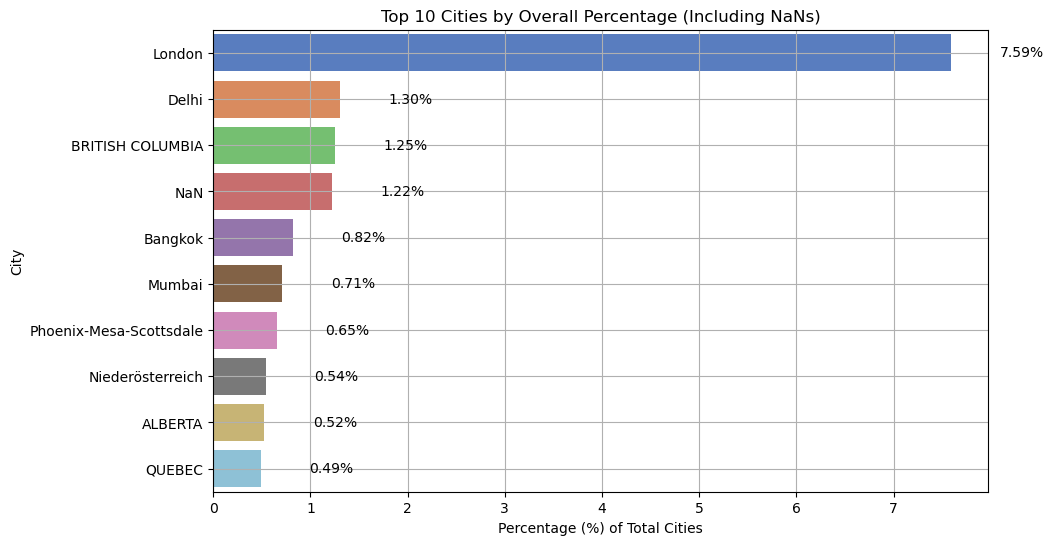

In [1175]:
# Replace NaN values in the 'city' column with 'NaN'
df_updated['city'].fillna('NaN', inplace=True)

# Calculate the counts including NaN values for all cities
city_counts_with_nan = df_updated['city'].value_counts().head(10)
total_count = df_updated['city'].count()

# Calculate percentages
city_percentages = (city_counts_with_nan / total_count) * 100

# Plot a horizontal bar chart with overall percentages
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=city_percentages, y=city_counts_with_nan.index, palette='muted')

# Annotating the bars with the percentage values
for i, (value, name) in enumerate(zip(city_percentages, city_counts_with_nan.index)):
    ax.text(value + 0.5, i, f'{value:.2f}%', color='black', va='center')

plt.title('Top 10 Cities by Overall Percentage (Including NaNs)')
plt.xlabel('Percentage (%) of Total Cities')
plt.ylabel('City')
plt.grid(True)
plt.show()

#### Since there's only 1.21% NaN values. They can be removed as there's not much loss in the data.

In [1177]:
df_cleaned = df_updated.dropna(subset=['city'])

df_cleaned.isna().sum()

location         756
city               0
country            0
pollutant          0
value              0
timestamp          0
unit               0
source_name        0
latitude           0
longitude          0
location_geom      0
dtype: int64

#### Just 756 rows with no location, they can be removed.

In [1179]:
df_cleaned = df_updated.dropna(subset=['location'])

df_cleaned.isna().sum()

location         0
city             0
country          0
pollutant        0
value            0
timestamp        0
unit             0
source_name      0
latitude         0
longitude        0
location_geom    0
dtype: int64

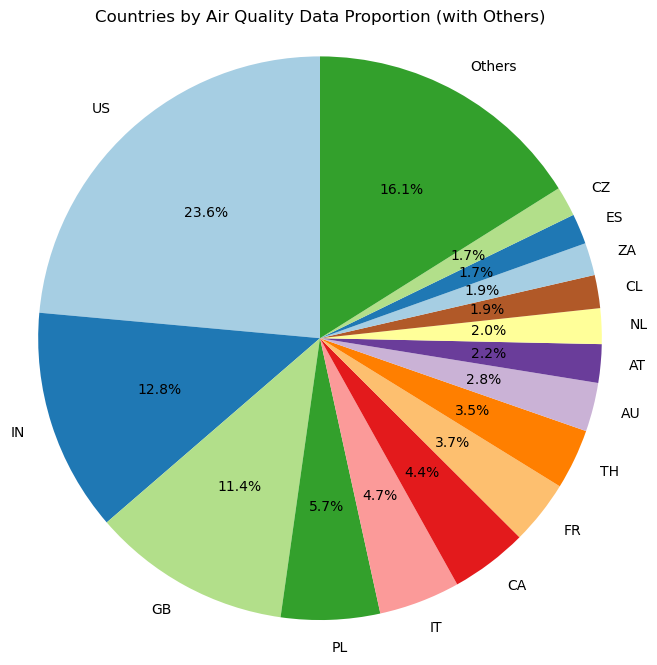

In [1180]:
# Get the count of occurrences for each country
country_counts = df_cleaned['country'].value_counts()

# Calculate total occurrences
total_count = country_counts.sum()

# Filter countries that have more than 1.5% of total occurrences
major_countries = country_counts[country_counts / total_count >= 0.015]

# Combine countries with less than 1.5% into 'Others'
other_countries = country_counts[country_counts / total_count < 0.015].sum()

# Append 'Others' to the major_countries
major_countries['Others'] = other_countries

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(major_countries, labels=major_countries.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Countries by Air Quality Data Proportion (with Others)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Show the plot
plt.show()

In [1181]:
# Display descriptive statistics for the numerical columns
df_cleaned.describe()

,value,latitude,longitude
count,6.030300e+06,6.030300e+06,6.030300e+06
mean,4.244187e+01,5.868033e+00,3.079575e+01
std,1.259331e+04,1.385292e+01,2.421731e+01
min,-8.812000e+05,-7.201170e+01,-1.617670e+02
25%,7.000000e-01,1.000000e+00,2.206047e+01
50%,9.000000e+00,1.000000e+00,3.942689e+01
75%,2.800000e+01,1.000000e+00,4.775363e+01
max,2.664761e+07,7.890669e+01,1.534020e+02


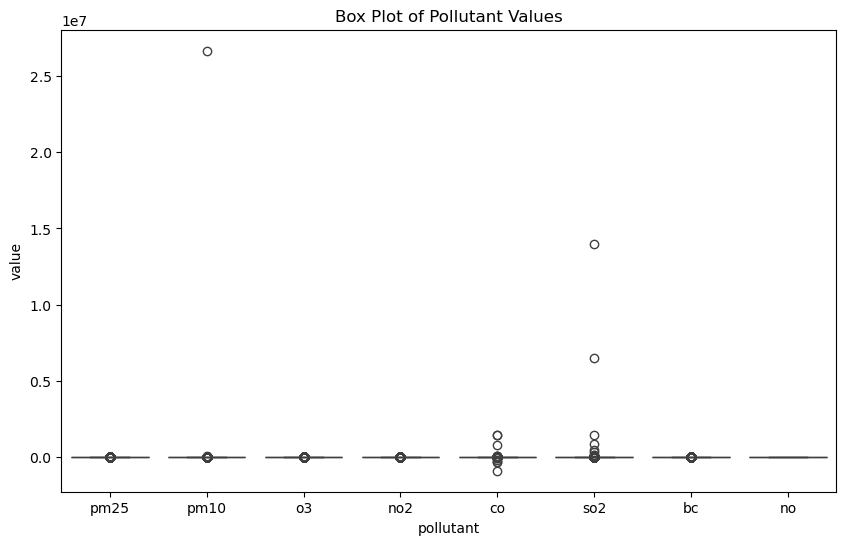

In [1182]:
# Boxplot for the pollutant value
plt.figure(figsize=(10, 6))
sns.boxplot(x='pollutant', y='value', data=df_cleaned)
plt.title('Box Plot of Pollutant Values')
plt.show()

#### There are negative values and outliers where the values are too high.

In [1184]:
# Remove rows with negative pollutant values
df_cleaned = df_cleaned[df_cleaned['value'] >= 0]

#### Step 2: Cap Extremely High Values
Here are the approximate max recorded pollutant values based on air quality data around the world:

pm25: 1000 µg/m³
pm10: 2000 µg/m³
o3: 500 µg/m³
no2: 1000 µg/m³
co: 30000 µg/m³
so2: 1000 µg/m³
bc: 100 µg/m³
no: 500 µg/m³

In [1186]:
# Define pollutant max recorded values (in µg/m³)
max_values = {
    'pm25': 1000,
    'pm10': 2000,
    'o3': 500,
    'no2': 1000,
    'co': 30000,
    'so2': 1000,
    'bc': 100,
    'no': 500
}

# Cap values based on the world max values for each pollutant
df_cleaned['value'] = df_cleaned.apply(
    lambda row: min(row['value'], max_values[row['pollutant']]) if row['pollutant'] in max_values else row['value'],
    axis=1
)

#### Step 3: Apply IQR Method to Remove Outliers
We'll apply the Interquartile Range (IQR) method to remove remaining outliers. This is done by calculating the IQR and removing rows where values are outside of 1.5 times the IQR from the first and third quartiles.

In [1188]:
# Function to apply IQR method
def remove_outliers_iqr(df, pollutant_column, value_column):
    pollutants = df[pollutant_column].unique()
    filtered_df = pd.DataFrame()
    
    for pollutant in pollutants:
        subset = df[df[pollutant_column] == pollutant]
        Q1 = subset[value_column].quantile(0.25)
        Q3 = subset[value_column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Filtering values within the range of Q1 - 1.5*IQR and Q3 + 1.5*IQR
        filtered_subset = subset[
            (subset[value_column] >= (Q1 - 1.5 * IQR)) & 
            (subset[value_column] <= (Q3 + 1.5 * IQR))
        ]
        
        filtered_df = pd.concat([filtered_df, filtered_subset])
    
    return filtered_df

# Apply IQR method
df_cleaned = remove_outliers_iqr(df_cleaned, 'pollutant', 'value')

#### Step 4: Visualize the Cleaned Data
After cleaning, you can re-plot the box plot to see the cleaned data.

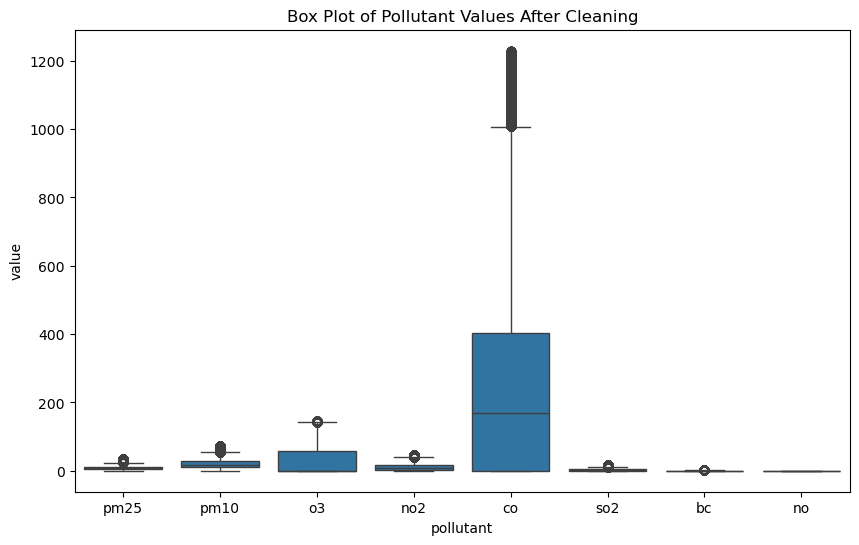

In [1190]:
# Re-plot the box plot after cleaning
plt.figure(figsize=(10, 6))
sns.boxplot(x='pollutant', y='value', data=df_cleaned)
plt.title('Box Plot of Pollutant Values After Cleaning')
plt.show()

#### Now the outliers have been removed and it looks much clearer.

#### There were location and cities which are in Chinese, as seen from the output when using OpenCage API. These need to be translated to English.

In [ ]:
import re

# Function to check if a string contains Chinese characters
def contains_chinese(text):
    if isinstance(text, str):
        return bool(re.search(r'[\u4e00-\u9fff]', text))
    return False

# Apply the function to the 'city' and 'location' columns
chinese_rows = df_cleaned[(df_cleaned['city'].apply(contains_chinese)) | (df_cleaned['location'].apply(contains_chinese))]

# Display the rows with Chinese characters
print(chinese_rows)

In [ ]:
# Extract unique countries in the 'chinese_rows' dataframe
unique_countries_in_chinese_rows = chinese_rows['country'].unique()

unique_countries_in_chinese_rows

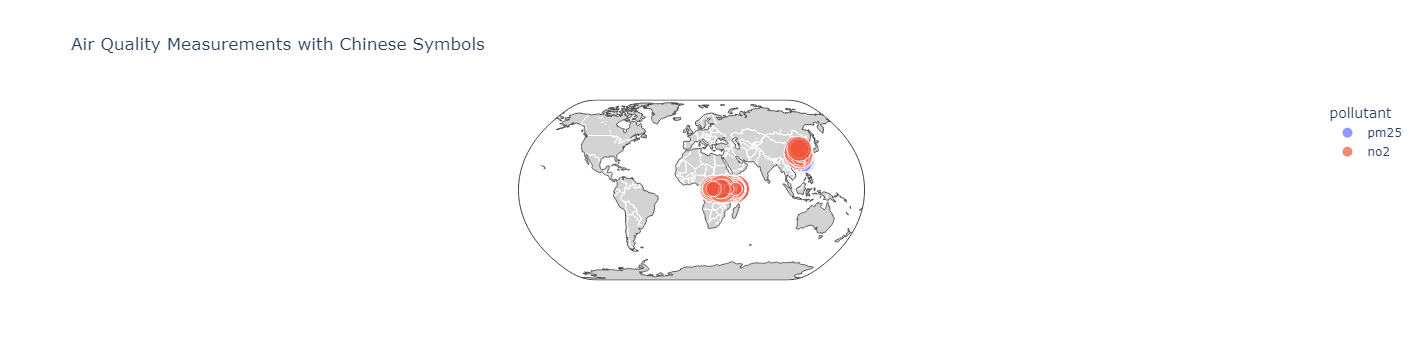

In [926]:
import plotly.express as px

# Subset the data for visualization (example: focusing on specific pollutants or countries)
df_viz = df_cleaned[(df_cleaned['country'].isin(['CN', 'TW'])) & (df_cleaned['pollutant'].isin(['no2', 'pm25']))]

# Create a scatter_geo plot
fig = px.scatter_geo(df_viz,
                     lat='latitude',
                     lon='longitude',
                     hover_name='location',  # Tooltip with location names
                     hover_data=['city', 'pollutant', 'value'],  # Additional info in tooltip
                     color='pollutant',  # Color points by pollutant
                     size='value',  # Size points based on pollutant value
                     projection='natural earth',  # Use the 'natural earth' map projection
                     title='Air Quality Measurements with Chinese Symbols')

fig.update_layout(geo=dict(
    showland=True,  # Show land
    showcountries=True,  # Show country borders
    landcolor='lightgray',  # Set land color
    countrycolor='white'  # Set country border color
))

fig.show()

#### There are places in Africa which are marked as locations in China. Either they have to be removed or tagged to the right location.

In [796]:
# Filter rows from the chinese_rows DataFrame that have latitude and longitude values corresponding to Africa
# These points likely have incorrect coordinates or data classification
# Define a rough latitude and longitude range for China and Taiwan to filter out African locations
china_taiwan_lat_range = (15.0, 55.0)  # Latitude range for China and Taiwan
china_taiwan_lon_range = (70.0, 140.0)  # Longitude range for China and Taiwan

# Filter for rows outside the expected latitude and longitude ranges for China and Taiwan
misclassified_rows = chinese_rows[
    ~((chinese_rows['latitude'].between(*china_taiwan_lat_range)) & 
      (chinese_rows['longitude'].between(*china_taiwan_lon_range)))
]

# Display the misclassified rows that fall outside the range of China and Taiwan
misclassified_rows

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,location_geom
3487,Pingzhen,桃園市,TW,pm25,9.0,2017-12-22 05:00:00+00:00,µg/m³,Taiwan,1.0,24.952786,POINT(24.952786 1)
3488,Shilin,臺北市,TW,pm25,13.0,2017-12-22 05:00:00+00:00,µg/m³,Taiwan,1.0,25.105417,POINT(25.105417 1)
3856,Taoyuan,桃園市,TW,pm25,22.0,2018-02-22 00:00:00+00:00,µg/m³,Taiwan,1.0,24.994789,POINT(24.994789 1)
3872,Matsu,連江縣,TW,pm25,13.0,2018-02-22 00:00:00+00:00,µg/m³,Taiwan,1.0,26.160469,POINT(26.160469 1)
3874,FugueiCape,新北市,TW,pm25,27.0,2018-02-22 00:00:00+00:00,µg/m³,Taiwan,1.0,25.294147,POINT(25.294147 1)
...,...,...,...,...,...,...,...,...,...,...,...
38392,西溪,杭州市,CN,so2,8.0,2021-08-09 11:00:00+00:00,µg/m³,ChinaAQIData,1.0,30.274700,POINT(30.2747 1)
38396,龙井湾,重庆市,CN,so2,10.0,2021-08-09 11:00:00+00:00,µg/m³,ChinaAQIData,1.0,29.572800,POINT(29.5728 1)
38405,矿山设计院,连云港市,CN,so2,1.0,2021-08-09 11:00:00+00:00,µg/m³,ChinaAQIData,1.0,34.591100,POINT(34.5911 1)
38412,市环境监测站,达州市,CN,so2,7.0,2021-08-09 11:00:00+00:00,µg/m³,ChinaAQIData,1.0,31.218600,POINT(31.2186 1)


In [804]:
# Get the unique latitude and longitude combinations
unique_lat_long_misclassified = misclassified_rows[['latitude', 'longitude']].drop_duplicates()

# Display the unique latitude and longitude
unique_lat_long_misclassified

,latitude,longitude
3487,1.0,24.952786
3488,1.0,25.105417
3856,1.0,24.994789
3872,1.0,26.160469
3874,1.0,25.294147
...,...,...
37685,1.0,42.070500
37806,1.0,36.772900
38154,1.0,36.041400
28995,1.0,31.683700


In [806]:
# Set 'city', 'location', and 'country' as NaN in the misclassified rows
misclassified_rows['city'] = None
misclassified_rows['location'] = None
misclassified_rows['country'] = None

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\1732853129.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\1732853129.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\1732853129.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [812]:
from opencage.geocoder import OpenCageGeocode
import time

# Initialize OpenCage API
key = 'df1636008c4a4220802d29a87337b304'  # Replace with your OpenCage API key
geocoder = OpenCageGeocode(key)

# Function to reverse geocode lat-long and get city, location, and country
def reverse_geocode(lat, lon):
    result = geocoder.reverse_geocode(lat, lon, no_annotations='1', language='en')
    if result and len(result):
        address = result[0]['components']
        city = address.get('city', None)
        location = address.get('road', None)  # Adjust this based on what you want for 'location'
        country = address.get('country', None)
        return city, location, country
    return None, None, None

# Create a dictionary to store the results
lat_long_to_location = {}

# Loop through the unique lat-long values and get the location details
for idx, row in unique_lat_long_misclassified.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    
    city, location, country = reverse_geocode(lat, lon)
    print(f"Processed lat: {lat}, lon: {lon} -> City: {city}, Location: {location}, Country: {country}")
    
    # Save the result in the dictionary
    lat_long_to_location[(lat, lon)] = {'city': city, 'location': location, 'country': country}

# Convert the dictionary to a DataFrame for easier merging
geo_data = pd.DataFrame.from_dict(lat_long_to_location, orient='index').reset_index()
geo_data.columns = ['latitude', 'longitude', 'city', 'location', 'country']

Processed lat: 1.0, lon: 24.952786 -> City: None, Location: None, Country: Democratic Republic of the Congo
Processed lat: 1.0, lon: 25.105417 -> City: None, Location: None, Country: Democratic Republic of the Congo
Processed lat: 1.0, lon: 24.994789 -> City: None, Location: None, Country: Democratic Republic of the Congo
Processed lat: 1.0, lon: 26.160469 -> City: None, Location: None, Country: Democratic Republic of the Congo
Processed lat: 1.0, lon: 25.294147 -> City: None, Location: None, Country: Democratic Republic of the Congo
Processed lat: 1.0, lon: 37.0308 -> City: Wamba West ward, Location: None, Country: Kenya
Processed lat: 1.0, lon: 32.5039 -> City: None, Location: unnamed road, Country: Uganda
Processed lat: 1.0, lon: 37.9358 -> City: Waso ward, Location: None, Country: Kenya
Processed lat: 1.0, lon: 27.8042 -> City: None, Location: None, Country: Democratic Republic of the Congo
Processed lat: 1.0, lon: 34.7975 -> City: None, Location: unnamed road, Country: Kenya
Proce

RateLimitExceededError: You have used the requests available on your plan. Please purchase more if you wish to continue: https://opencagedata.com/pricing

### Even with the OpenCage API it wasn't possible to get the city and location for the misclassified rows. Hence, dropping them.

In [1095]:
# Function to check if a string contains Chinese characters
def contains_chinese(text):
    if isinstance(text, str):
        return bool(re.search(r'[\u4e00-\u9fff]', text))
    return False

# Identify rows containing Chinese characters in 'city' or 'location'
chinese_rows = df_cleaned[(df_cleaned['city'].apply(contains_chinese)) | (df_cleaned['location'].apply(contains_chinese))]

chinese_rows

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,location_geom


In [1096]:
# Drop rows that have Chinese characters in 'city' or 'location'
df_cleaned = df_cleaned[~df_cleaned.index.isin(chinese_rows.index)]

# Display the updated DataFrame after removal
df_cleaned.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,location_geom
10,ADEPA - Asylum Down,Accra,GH,pm25,21.65,2007-04-08 06:54:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.57,-0.20,POINT(-0.2040278 5.567833)
11,ADEPA - Asylum Down,Accra,GH,pm25,21.65,2007-04-08 06:54:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,46.00,5.57,POINT(5.567833 46)
13,JTT - Jamestown,Accra,GH,pm25,14.91,2007-07-11 07:25:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,26.00,5.53,POINT(5.5334556 26)
15,JTT - Jamestown,Accra,GH,pm25,14.91,2007-07-11 07:25:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.53,-0.21,POINT(-0.2129917 5.5334554)
18,ELT - East Legon,Accra,GH,pm25,19.40,2007-09-05 06:50:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.64,-0.17,POINT(-0.1695437 5.6408997)


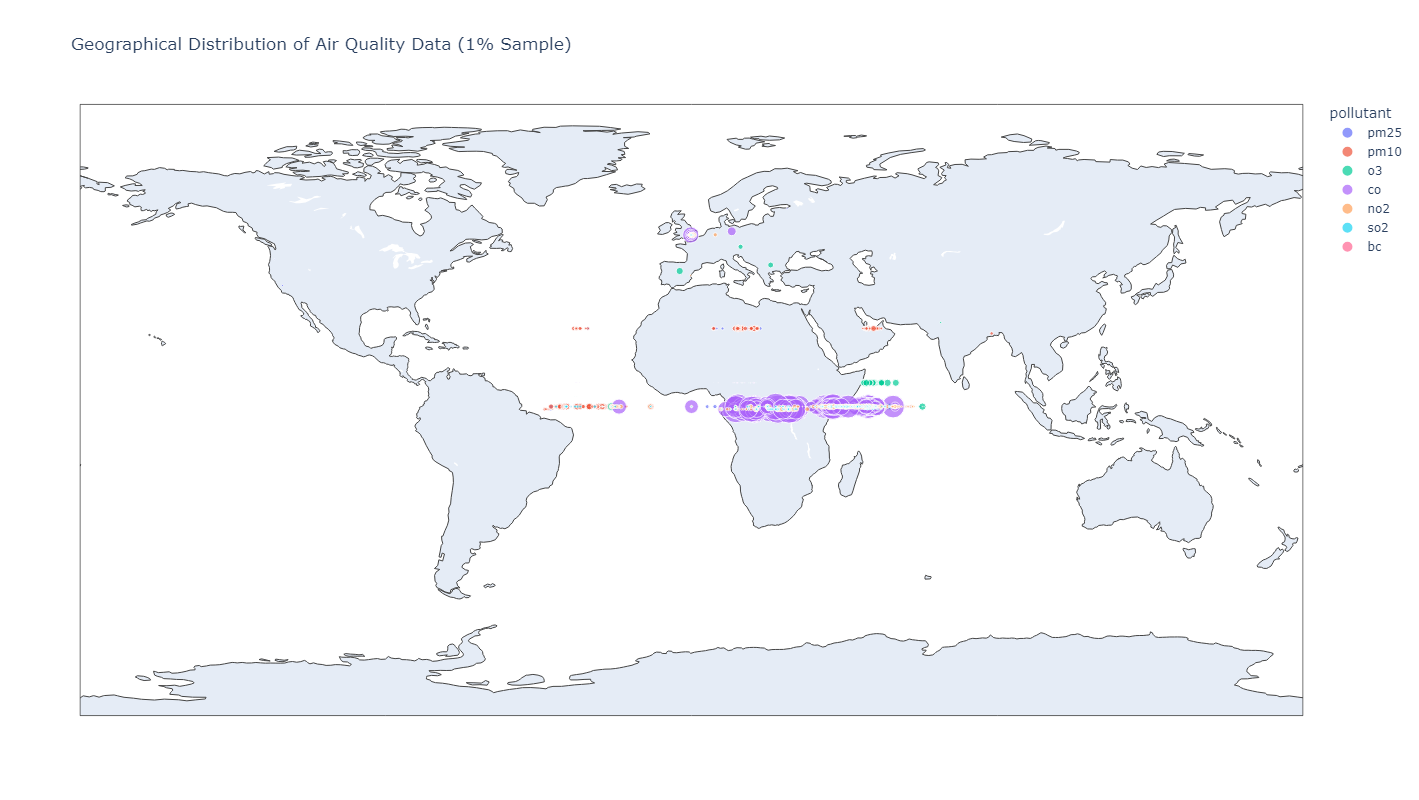

In [1225]:
import plotly.express as px

# Sample 0.1% of the data
df_sampled = df_cleaned.sample(frac=0.001, random_state=42)

# Increase figure size
fig = px.scatter_geo(df_sampled, lat='latitude', lon='longitude', 
                     color='pollutant', size='value',
                     title='Geographical Distribution of Air Quality Data (1% Sample)',
                     width=1200, height=800)  # Adjust width and height for larger display

# Show the plot
fig.show()

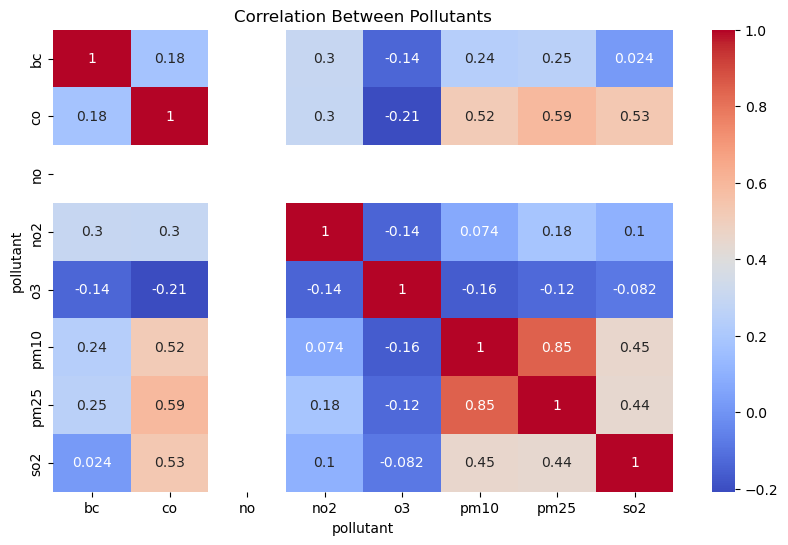

In [1227]:
plt.figure(figsize=(10, 6))
pollutant_pivot = df_cleaned.pivot_table(values='value', index='timestamp', columns='pollutant', aggfunc='mean')
sns.heatmap(pollutant_pivot.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutants')
plt.show()

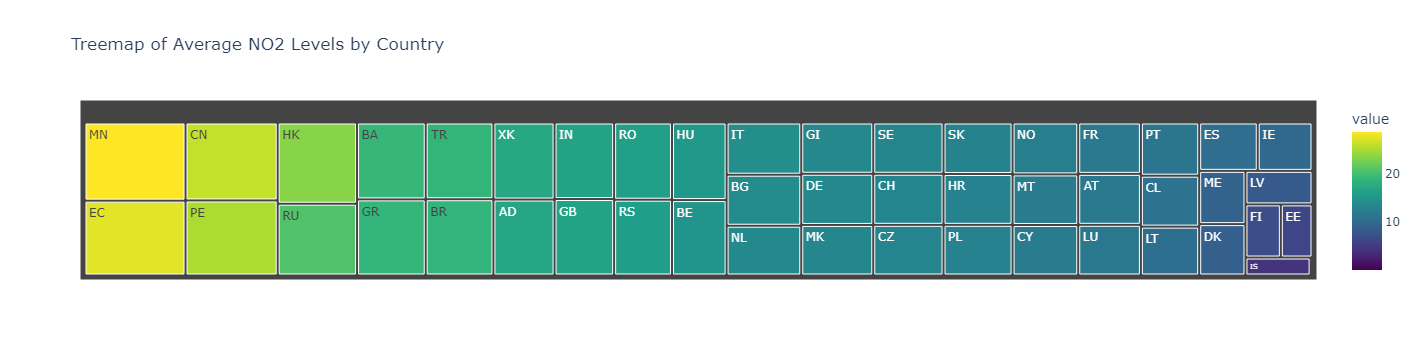

In [1241]:
# Filter for NO2 data
df_no2 = df_cleaned[df_cleaned['pollutant'] == 'no2']

# Calculate the average NO2 value by country
country_no2_avg = df_no2.groupby('country')['value'].mean().reset_index()

# Create the treemap for NO2
fig = px.treemap(country_no2_avg, path=['country'], values='value',
                 title='Treemap of Average NO2 Levels by Country',
                 color='value', hover_data=['country'], color_continuous_scale='Viridis')

fig.show()

#### NO2 is a significant air pollutant primarily produced from burning fossil fuels. It affects air quality and poses health risks, contributing to respiratory issues and environmental challenges like acid rain.

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\2377458330.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\thall\AppData\Local\Temp\ipykernel_15012\2377458330.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\thall\AppData\Local\Temp\ipykernel_15012\2377458330.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\thall\AppData\Local\Temp\ipykernel_15012\2377458330.py:21: FutureWarning:





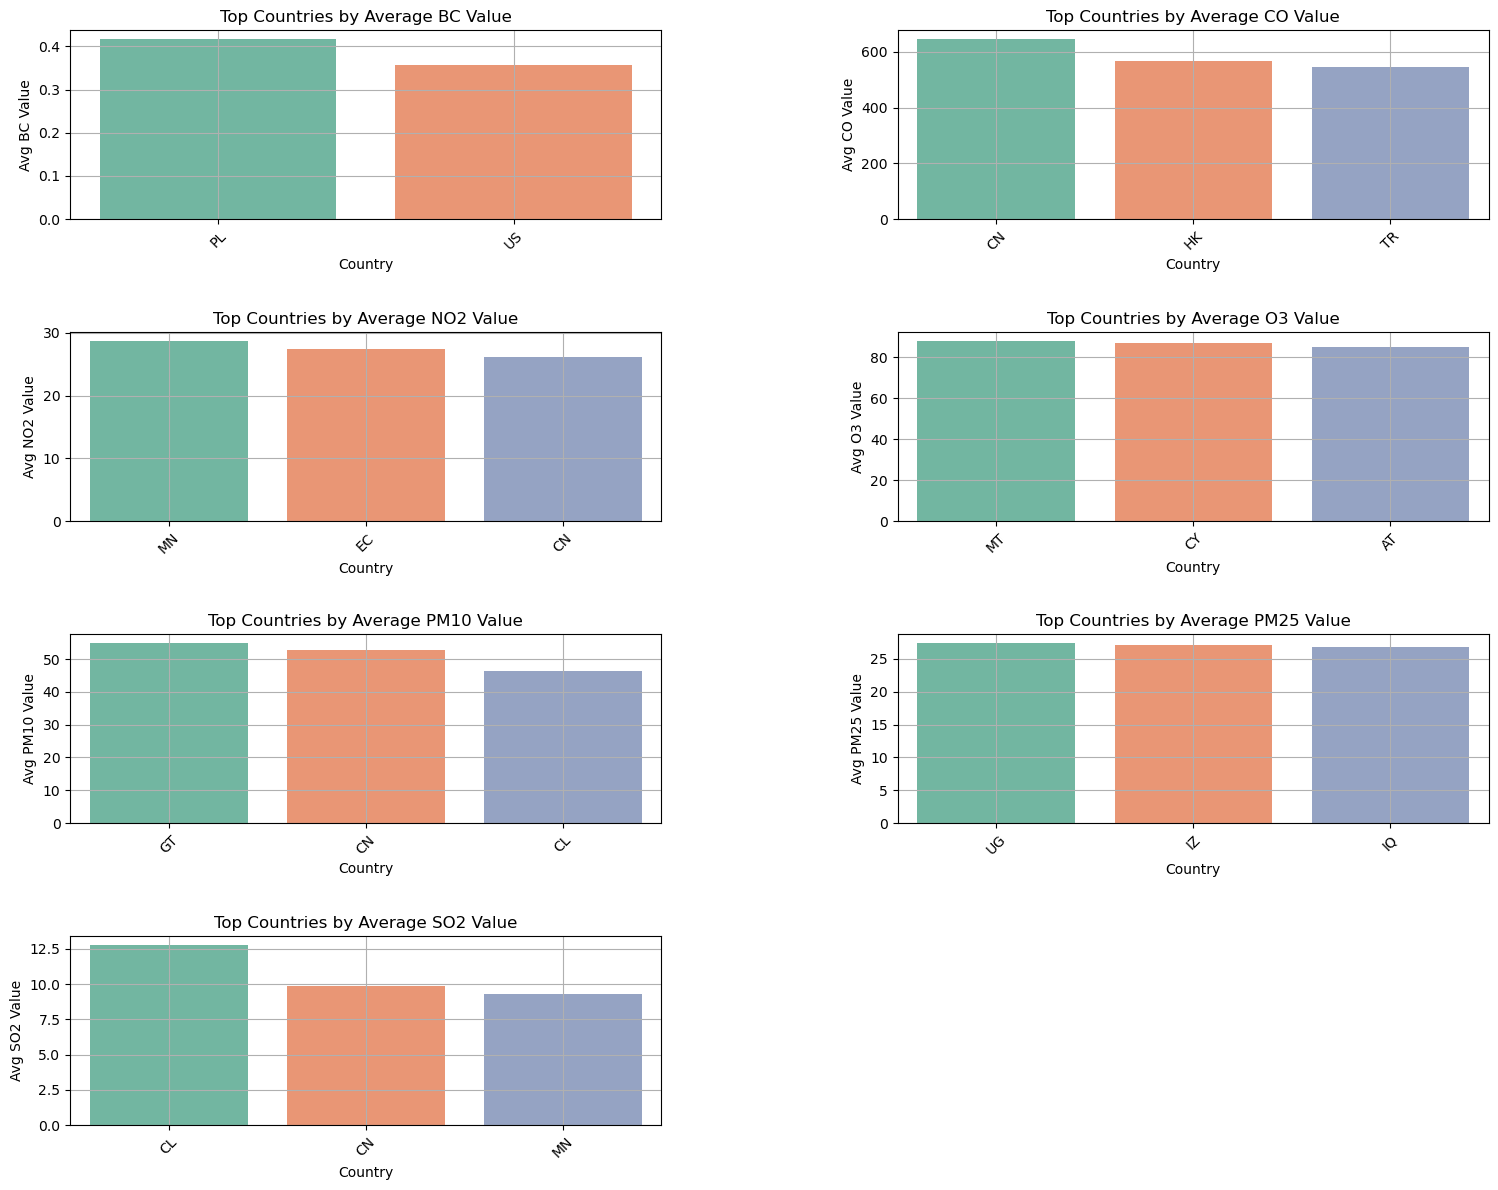

In [1325]:
# Get the top 3 countries for each pollutant, or all countries if fewer than 3 exist
def get_top_countries(data, top_n=3):
    if len(data) < top_n:
        return data
    return data.nlargest(top_n, 'value')

# Group by pollutant and apply the top 3 or all countries function
top_countries_by_pollutant = country_pollutant_avg.groupby('pollutant').apply(get_top_countries).reset_index(drop=True)

# Create a 4x2 grid of smaller bar plots for each pollutant
fig, axes = plt.subplots(4, 2, figsize=(15, 12))  # Adjust figure size for better readability
axes = axes.flatten()

# Get unique pollutants
unique_pollutants = top_countries_by_pollutant['pollutant'].unique()

# Plot each pollutant in a separate subplot
for i, pollutant in enumerate(unique_pollutants):
    pollutant_data = top_countries_by_pollutant[top_countries_by_pollutant['pollutant'] == pollutant]
    
    sns.barplot(x='country', y='value', data=pollutant_data, ax=axes[i], palette='Set2')
    
    axes[i].set_title(f'Top Countries by Average {pollutant.upper()} Value')
    axes[i].set_xlabel('Country')
    axes[i].set_ylabel(f'Avg {pollutant.upper()} Value')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout with more spacing between rows and columns
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# Show the plot
plt.show()

#### There seems to be no values of 'no'.

In [1330]:
# Check for rows where the 'pollutant' column has the value 'no'
no_pollutant_value_rows = df_cleaned[df_cleaned['pollutant'] == 'no']

# Display the rows where the pollutant value is 'no'
no_pollutant_value_rows

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,location_geom
5514324,Parkway East (Near R),Pittsburgh,US,no,0.007021,2020-11-01 04:00:00+00:00,ppm,AirNow,1.0,40.44,POINT(40.437431 1)


#### There's just 1 row with pollutant 'no'. Its best to remove it.

In [1333]:
# Drop the row where the pollutant value is 'no'
df_cleaned = df_cleaned[df_cleaned['pollutant'] != 'no']

# Confirm that the row has been dropped
print(df_cleaned[df_cleaned['pollutant'] == 'no'])

Empty DataFrame
Columns: [location, city, country, pollutant, value, timestamp, unit, source_name, latitude, longitude, location_geom]
Index: []


#### The location_geom column is essentially redundant if it just stores the geographic point in a format like POINT(lat lon) since latitude and longitude themselves can provide the same information more clearly and directly.

In [1336]:
# Drop the location_geom column from the dataframe
df_cleaned = df_cleaned.drop(columns=['location_geom'])

In [1339]:
df_cleaned.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude
0,ADEPA - Asylum Down,Accra,GH,pm25,21.65,2007-04-08 06:54:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.57,-0.20
1,ADEPA - Asylum Down,Accra,GH,pm25,21.65,2007-04-08 06:54:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,46.00,5.57
2,JTT - Jamestown,Accra,GH,pm25,14.91,2007-07-11 07:25:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,26.00,5.53
3,JTT - Jamestown,Accra,GH,pm25,14.91,2007-07-11 07:25:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.53,-0.21
4,ELT - East Legon,Accra,GH,pm25,19.40,2007-09-05 06:50:00+00:00,µg/m³,Dr. Raphael E. Arku and Colleagues,5.64,-0.17


In [1343]:
df_cleaned.shape

(5514324, 10)